# NFL COMBINE DATA

This notebook will collect data from Kaggle.com on draft data and perform various analyzations on that data.  The goal of this notebook is to be able to predict where certain players will be drafted using a Random Forrest algorithm.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import category_encoders as ce
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score

# Collect Data

In [2]:
combine_data = pd.read_csv("combine.csv")
combine_data.head()

,combineId,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nameFull,college,ageAtDraft,combineArm,combine40yd,combineVert,combineBench,combineShuttle,combineBroad,combine3cone,combine60ydShuttle
0,10000,1987,CB,69.8,198,8.50,Michael Adams,Arkansas State,23.076712,30.50,4.42,32.0,13.0,4.60,118.0,NaN,11.91
1,10001,1987,C,74.8,266,10.25,John Adickes,Baylor,22.843836,30.00,4.97,26.5,25.0,4.60,103.0,NaN,NaN
2,10002,1987,FB,71.8,217,9.00,Tommy Agee,Auburn,NaN,30.75,NaN,NaN,15.0,NaN,NaN,NaN,NaN
3,10003,1987,C,75.0,279,10.50,David Alexander,Tulsa (OK),22.764384,32.75,5.13,27.5,22.0,4.33,105.0,NaN,NaN
4,10004,1987,WR,72.1,202,10.00,Lyneal Alston,Southern Miss,22.778082,33.00,4.64,32.0,7.0,4.52,114.0,NaN,11.85


In [3]:
draft_data = pd.read_csv("draft.csv")
draft_data.head()

,round,pick,combineId
0,1.0,1,10236.0
1,1.0,2,NaN
2,1.0,3,10098.0
3,1.0,4,NaN
4,1.0,5,NaN


# Join Draft and Combine Data

The data for the combine and draft are in separate dataframes.  These dataframes need to be joined on the combineId to create a dataframe that is useful for this project.

Any players drafted that did not participate in the combine will not be included in the dataframe.

In [4]:
#It is important to perform a left join in this scenario so that the data contains information on undrafted players
#An Inner join would only contain data for players that have a draft pick associated with them
prospect_data = pd.merge(combine_data, draft_data, on = "combineId", how = "left")
prospect_data.head()

,combineId,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nameFull,college,ageAtDraft,combineArm,combine40yd,combineVert,combineBench,combineShuttle,combineBroad,combine3cone,combine60ydShuttle,round,pick
0,10000,1987,CB,69.8,198,8.50,Michael Adams,Arkansas State,23.076712,30.50,4.42,32.0,13.0,4.60,118.0,NaN,11.91,3.0,67.0
1,10001,1987,C,74.8,266,10.25,John Adickes,Baylor,22.843836,30.00,4.97,26.5,25.0,4.60,103.0,NaN,NaN,6.0,154.0
2,10002,1987,FB,71.8,217,9.00,Tommy Agee,Auburn,NaN,30.75,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10003,1987,C,75.0,279,10.50,David Alexander,Tulsa (OK),22.764384,32.75,5.13,27.5,22.0,4.33,105.0,NaN,NaN,5.0,121.0
4,10004,1987,WR,72.1,202,10.00,Lyneal Alston,Southern Miss,22.778082,33.00,4.64,32.0,7.0,4.52,114.0,NaN,11.85,NaN,NaN


# Preprocess Manipulate And Understand Data

In order to prepare the data for processing the college data must be encoded.

The NFL draft was decreased to its current amount of rounds(7) in 1995.  Thus the extra rounds of data will only hurt our model since they would be undrafted players in the current nfl era.  Any rounds after 7 will be treated as undrafted player data.

The measurments have very different meanings for each position.  For this reason I will separate the data into position groups.  Quarterbacks, offensive lineman, tight ends, fullbacks, kickers, and inside defensive linemen will not be included in the creation of these models.  The combine should be more predictive of "skill" position player success, and thus the major correlations should reside within the "skill" positions

In [5]:
#Treat prospects drafted after round 7 as undrafted with a value of 8
prospect_data.loc[prospect_data['round'] > 7, 'round'] = 8
prepared_data = prospect_data

## Encode Data

In [6]:
#Encode colleges

encoder = ce.BinaryEncoder(cols = ['college'], return_df = True)

prepared_data = encoder.fit_transform(prospect_data)

prepared_data.head()

,combineId,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nameFull,college_0,college_1,college_2,...,combineArm,combine40yd,combineVert,combineBench,combineShuttle,combineBroad,combine3cone,combine60ydShuttle,round,pick
0,10000,1987,CB,69.8,198,8.50,Michael Adams,0,0,0,...,30.50,4.42,32.0,13.0,4.60,118.0,NaN,11.91,3.0,67.0
1,10001,1987,C,74.8,266,10.25,John Adickes,0,0,0,...,30.00,4.97,26.5,25.0,4.60,103.0,NaN,NaN,6.0,154.0
2,10002,1987,FB,71.8,217,9.00,Tommy Agee,0,0,0,...,30.75,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
3,10003,1987,C,75.0,279,10.50,David Alexander,0,0,0,...,32.75,5.13,27.5,22.0,4.33,105.0,NaN,NaN,5.0,121.0
4,10004,1987,WR,72.1,202,10.00,Lyneal Alston,0,0,0,...,33.00,4.64,32.0,7.0,4.52,114.0,NaN,11.85,NaN,NaN


## Manipulate Data

In [7]:
#Manipulate data and handle some general NaN values

#name values will not be needed
prepared_data.drop(['nameFull'], axis = 1, inplace=True)

#All undrafted players be represented by an 8
prepared_data['round'].fillna(8, inplace=True)

#NaN age values will be replaced by the mean
prepared_data['ageAtDraft'].fillna(prepared_data['ageAtDraft'].mean(), inplace=True)

#40 times are too important to have NaN values so prospects with NaN values will not be included in the data
prepared_data.dropna(subset=['combine40yd'], inplace=True)

prepared_data.head()

,combineId,combineYear,combinePosition,combineHeight,combineWeight,combineHand,college_0,college_1,college_2,college_3,...,combineArm,combine40yd,combineVert,combineBench,combineShuttle,combineBroad,combine3cone,combine60ydShuttle,round,pick
0,10000,1987,CB,69.8,198,8.50,0,0,0,0,...,30.50,4.42,32.0,13.0,4.60,118.0,NaN,11.91,3.0,67.0
1,10001,1987,C,74.8,266,10.25,0,0,0,0,...,30.00,4.97,26.5,25.0,4.60,103.0,NaN,NaN,6.0,154.0
3,10003,1987,C,75.0,279,10.50,0,0,0,0,...,32.75,5.13,27.5,22.0,4.33,105.0,NaN,NaN,5.0,121.0
4,10004,1987,WR,72.1,202,10.00,0,0,0,0,...,33.00,4.64,32.0,7.0,4.52,114.0,NaN,11.85,8.0,NaN
5,10005,1987,DE,76.5,273,8.75,0,0,0,0,...,34.00,4.86,28.5,18.0,4.49,108.0,NaN,NaN,8.0,201.0


## Separate Position Groups

In [8]:
prepared_data['combinePosition'].value_counts()

WR     1208
CB      888
RB      834
DE      696
OT      689
OLB     684
DT      662
OG      560
TE      536
QB      529
FS      344
ILB     344
SS      304
C       275
FB      208
LB       59
DL       52
DB       50
OL       43
S        22
EDG      18
P        14
K        11
LS        6
Name: combinePosition, dtype: int64

In [9]:
WR = prepared_data[(prepared_data['combinePosition'] == 'WR')]

RB = prepared_data[(prepared_data['combinePosition'] == 'RB')]

LB = prepared_data[(prepared_data['combinePosition'] == 'LB') |
                   (prepared_data['combinePosition'] == 'ILB') |
                   (prepared_data['combinePosition'] == 'OLB')]

EDG = prepared_data[(prepared_data['combinePosition'] == 'DE') |
                    (prepared_data['combinePosition'] == 'EDG')]

CB = prepared_data[(prepared_data['combinePosition'] == 'CB')]

S = prepared_data[(prepared_data['combinePosition'] == 'S') |
                  (prepared_data['combinePosition'] == 'FS') |
                  (prepared_data['combinePosition'] == 'SS')]

Skill = prepared_data[(prepared_data['combinePosition'] == 'WR') |
                      (prepared_data['combinePosition'] == 'RB') |
                      (prepared_data['combinePosition'] == 'CB') |
                      (prepared_data['combinePosition'] == 'S') |
                      (prepared_data['combinePosition'] == 'FS') |
                      (prepared_data['combinePosition'] == 'SS')]

To create a better understanding of how the different performance metrics will affect where prospects are drafted, it is crucial to separate the prospects by positions.  Each metric within each position group will create different value for players come draft day.

## Position Metric Comparisons

The histogram below shows how much different the 40 yard dash times recorded by corners, edge rushers, and linebackers will be.

Text(0.5, 1.0, '40 Yard Dash Histogram')

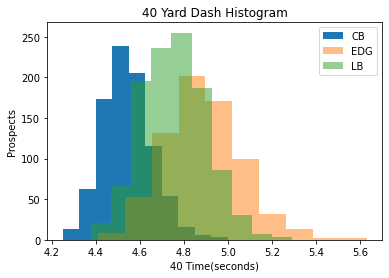

In [10]:
#Create Histogram of 40 yd times for CB, EDG, and LB
plt.hist(x=CB["combine40yd"], label = "CB", stacked=True)
plt.hist(x=EDG["combine40yd"], label = "EDG", alpha=.5)
plt.hist(x=LB["combine40yd"], label = "LB", alpha=.5)
plt.legend(loc = "upper right")
plt.xlabel("40 Time(seconds)")
plt.ylabel("Prospects")
plt.title("40 Yard Dash Histogram")

The top end speed for edge rushers and linebackers would only be average to below average for corners.  This means a 4.6s time ran by a corner would produce a low draft value, whereas it would produce an extremely high value for an edge rusher.

The tables below show various statistical analysis for 40 times, broad jumps, and verticals for each position.

In [11]:
CB[['combine40yd', 'combineBroad', 'combineVert']].describe()

,combine40yd,combineBroad,combineVert
count,888.000000,815.000000,816.000000
mean,4.543198,119.522699,35.139093
std,0.112820,5.937981,2.972050
min,4.250000,95.000000,26.000000
25%,4.470000,116.000000,33.000000
50%,4.530000,120.000000,35.000000
75%,4.610000,123.000000,37.000000
max,5.000000,136.000000,45.000000


In [12]:
EDG[['combine40yd', 'combineBroad', 'combineVert']].describe()

,combine40yd,combineBroad,combineVert
count,714.000000,638.000000,655.000000
mean,4.883473,112.995298,32.114504
std,0.171998,7.074950,3.368865
min,4.410000,82.000000,20.500000
25%,4.762500,108.000000,30.000000
50%,4.870000,113.000000,32.000000
75%,4.980000,118.000000,34.500000
max,5.630000,134.000000,42.000000


In [13]:
LB[['combine40yd', 'combineBroad', 'combineVert']].describe()

,combine40yd,combineBroad,combineVert
count,1087.000000,986.000000,984.000000
mean,4.756587,115.090264,33.217480
std,0.141403,6.379294,3.350948
min,4.380000,94.000000,23.000000
25%,4.650000,111.000000,31.000000
50%,4.750000,115.000000,33.000000
75%,4.850000,119.000000,35.500000
max,5.290000,139.000000,45.500000


The statistical analysis for each category displays how much different the average times(in seconds) and jumps (in inches) will be based on position.

The more skilled position groups such as WR, CB, S, and RB will have similar averages in these areas

In [14]:
WR[['combine40yd', 'combineBroad', 'combineVert']].describe()

,combine40yd,combineBroad,combineVert
count,1208.000000,1102.000000,1128.000000
mean,4.555952,118.479129,34.359309
std,0.119619,6.224751,3.227250
min,4.210000,99.000000,24.000000
25%,4.470000,114.000000,32.000000
50%,4.550000,118.000000,34.500000
75%,4.630000,123.000000,36.500000
max,4.990000,141.000000,45.000000


In [15]:
RB[['combine40yd', 'combineBroad', 'combineVert']].describe()

,combine40yd,combineBroad,combineVert
count,834.000000,766.000000,783.000000
mean,4.595935,116.796345,33.917241
std,0.122024,6.137661,3.128263
min,4.270000,97.000000,25.500000
25%,4.500000,113.000000,31.750000
50%,4.590000,117.000000,34.000000
75%,4.680000,121.000000,36.000000
max,5.020000,137.000000,43.500000


In [16]:
S[['combine40yd', 'combineBroad', 'combineVert']].describe()

,combine40yd,combineBroad,combineVert
count,670.000000,608.000000,610.000000
mean,4.602851,118.740132,34.901967
std,0.112007,5.993536,3.085077
min,4.290000,100.000000,27.000000
25%,4.530000,115.000000,33.000000
50%,4.600000,119.000000,35.000000
75%,4.670000,122.000000,37.000000
max,5.020000,141.000000,46.000000


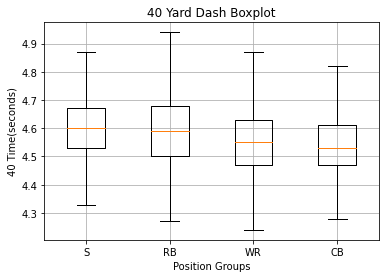

In [17]:
#Create boxplot to visualize the 40 yard dash averages
plt.boxplot([S["combine40yd"], RB["combine40yd"], WR["combine40yd"], CB['combine40yd']], labels=['S', 'RB', 'WR', 'CB'], showfliers=False,)
plt.xlabel("Position Groups")
plt.ylabel("40 Time(seconds)")
plt.title("40 Yard Dash Boxplot")
plt.grid()

While these metrics will be a little more similar, I believe the models will produce the best accuracy in predicting draft stock if each postion is separated.  The trends and differences in the importance of these metrics will still vary from position to position.

Also, it is important to note that the other metrics in this data set could still predict value based on position.  For example, big hands may be important for a receiver but may not mean anything for a safety, even though safety's and receiver's may have similar hand sizes.

## 40 Yard Dash Draft Round Comparison

Below is a line graph of the average 40 times per round for each position.

Text(0, 0.5, '40 Time(seconds)')

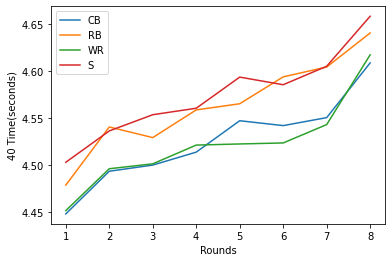

In [18]:
CB40Averages = [CB[CB['round'] == 1]['combine40yd'].mean(),
                CB[CB['round'] == 2]['combine40yd'].mean(),
                CB[CB['round'] == 3]['combine40yd'].mean(),
                CB[CB['round'] == 4]['combine40yd'].mean(),
                CB[CB['round'] == 5]['combine40yd'].mean(),
                CB[CB['round'] == 6]['combine40yd'].mean(),
                CB[CB['round'] == 7]['combine40yd'].mean(),
                CB[CB['round'] == 8]['combine40yd'].mean()]

RB40Averages = [RB[RB['round'] == 1]['combine40yd'].mean(),
                RB[RB['round'] == 2]['combine40yd'].mean(),
                RB[RB['round'] == 3]['combine40yd'].mean(),
                RB[RB['round'] == 4]['combine40yd'].mean(),
                RB[RB['round'] == 5]['combine40yd'].mean(),
                RB[RB['round'] == 6]['combine40yd'].mean(),
                RB[RB['round'] == 7]['combine40yd'].mean(),
                RB[RB['round'] == 8]['combine40yd'].mean()]

WR40Averages = [WR[WR['round'] == 1]['combine40yd'].mean(),
                WR[WR['round'] == 2]['combine40yd'].mean(),
                WR[WR['round'] == 3]['combine40yd'].mean(),
                WR[WR['round'] == 4]['combine40yd'].mean(),
                WR[WR['round'] == 5]['combine40yd'].mean(),
                WR[WR['round'] == 6]['combine40yd'].mean(),
                WR[WR['round'] == 7]['combine40yd'].mean(),
                WR[WR['round'] == 8]['combine40yd'].mean()]

S40Averages =  [S[S['round'] == 1]['combine40yd'].mean(),
                S[S['round'] == 2]['combine40yd'].mean(),
                S[S['round'] == 3]['combine40yd'].mean(),
                S[S['round'] == 4]['combine40yd'].mean(),
                S[S['round'] == 5]['combine40yd'].mean(),
                S[S['round'] == 6]['combine40yd'].mean(),
                S[S['round'] == 7]['combine40yd'].mean(),
                S[S['round'] == 8]['combine40yd'].mean()]

rounds = [1,2,3,4,5,6,7,8]

plt.plot(rounds, CB40Averages, label='CB')
plt.plot(rounds, RB40Averages, label='RB')
plt.plot(rounds, WR40Averages, label='WR')
plt.plot(rounds, S40Averages, label='S')
plt.legend(loc="upper left")
plt.xlabel('Rounds')
plt.ylabel('40 Time(seconds)')

The graph shows a clear trend of an increase in the amount of time it takes to sprint 40 yards for each position as the draft progresses.

Text(0, 0.5, '40 Time(seconds)')

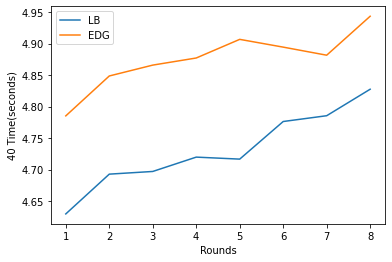

In [19]:
EDG40Averages =[EDG[EDG['round'] == 1]['combine40yd'].mean(),
                EDG[EDG['round'] == 2]['combine40yd'].mean(),
                EDG[EDG['round'] == 3]['combine40yd'].mean(),
                EDG[EDG['round'] == 4]['combine40yd'].mean(),
                EDG[EDG['round'] == 5]['combine40yd'].mean(),
                EDG[EDG['round'] == 6]['combine40yd'].mean(),
                EDG[EDG['round'] == 7]['combine40yd'].mean(),
                EDG[EDG['round'] == 8]['combine40yd'].mean()]

LB40Averages = [LB[LB['round'] == 1]['combine40yd'].mean(),
                LB[LB['round'] == 2]['combine40yd'].mean(),
                LB[LB['round'] == 3]['combine40yd'].mean(),
                LB[LB['round'] == 4]['combine40yd'].mean(),
                LB[LB['round'] == 5]['combine40yd'].mean(),
                LB[LB['round'] == 6]['combine40yd'].mean(),
                LB[LB['round'] == 7]['combine40yd'].mean(),
                LB[LB['round'] == 8]['combine40yd'].mean()]

rounds = [1,2,3,4,5,6,7,8]

plt.plot(rounds, LB40Averages, label='LB')
plt.plot(rounds, EDG40Averages, label='EDG')
plt.legend(loc="upper left")
plt.xlabel('Rounds')
plt.ylabel('40 Time(seconds)')

I grouped LB and EDG together because their average times are much slower than the groups in the other graph.

While there is still a trend of slower times for EDG rushers, the difference between the rounds is less of a margin than for RB, WR, CB, LB and S.

The predicition models that I will create will attempt to find how the importance of these small trends can lead to a prediciton of where players will be drafted.

# Creating the Models

First I test the position groups individually.  Each position group will go through various tests by removing and adding combine data columns to find which combination of data columns will produce the most accurate model.

The different variations that will be tested will not be included in this notebook because it would make this notebook way too long and impossible to follow.

Imputation of the remaining missing values will be done using multivariate imputation.  The imputation that was found to create the best model is a regression using the most predictive data column in the data set.

This code was used to sift through the different variations of models in order to find the best data combination for the creation of a model.  Various tests were run to check which combinations of data produced the most predicitve models.

Pick is always dropped from the data because it has a direct correlation to the round a player is drafted and would create a false model

In [20]:
#WR_prepared = WR.drop(['pick', 'combinePosition', 'combineHand', 'combineBench', 'combine3cone'], axis = 1)

Below is the code used to perform Multivariate Imputation of nan values

In [21]:
'''
imp = IterativeImputer(n_nearest_features = 1, random_state = 0)
WR_prepared = pd.DataFrame(imp.fit_transform(WR_prepared), columns = WR_prepared.columns)
'''

'\nimp = IterativeImputer(n_nearest_features = 1, random_state = 0)\nWR_prepared = pd.DataFrame(imp.fit_transform(WR_prepared), columns = WR_prepared.columns)\n'

This code was used in finding the most accurate model for each position group.  It mixes up the data in the creation of the models 100 times and averages the score of mixing the data in 100 different variations.  This code will be used in the creation of each model to give better insight into which data format will create the best model.

The code will be commented out in every instance because of the demand it would have on the notebook.  It is also unnecessary in the creation of the actual model. It is only there to show the entire process used in deciding on a final model.

In [22]:
'''
avg = 0

for x in range(100):

    x = WR_prepared.drop("round", axis = 1)
    y = WR_prepared["round"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

    model = RandomForestClassifier()
    model.fit(x_train, y_train)

    avg += model.score(x_test, y_test)

print(avg/100)
'''

'\navg = 0\n\nfor x in range(100):\n\n    x = WR_prepared.drop("round", axis = 1)\n    y = WR_prepared["round"]\n    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)\n\n    model = RandomForestClassifier()\n    model.fit(x_train, y_train)\n\n    avg += model.score(x_test, y_test)\n\nprint(avg/100)\n'

# Decision To Combine Skill Positions

After running through an extreme number of tests, I found some trends in creating the models.

Removing certain columns produced similar model scores independent of the position. Setting n_nearest_features=1 produced the best score when combined with taking exactly 5 columns out of the data set.

After many variations of testing, I decided to combine each "skill" position group into one to give the model more data to test.  This decision was made with the thought that position simply won't matter for combine data that correlates to what the NFL considers a "Skill position".  These positions include CB, S, RB, WR.

The model I create below produces the best score of any of the indiviual models I created.

## Skill

In [23]:
#This was the best data set I was able to create for creating a model
Skill_prepared = Skill.drop(['pick', 'combinePosition', 'combineHand', 'combineBench', 'combine3cone'], axis = 1)

The code below will be how imputation is going to be handled for all the models. N_nearest_features=1 will mean that only the most predictive column will be used for the regression of each missing value. 

In [24]:
imp = IterativeImputer(n_nearest_features = 1, random_state = 0)
Skill_prepared = pd.DataFrame(imp.fit_transform(Skill_prepared), columns = Skill_prepared.columns)

In [25]:
'''
avg = 0

for x in range(100):

    x = Skill_prepared.drop("round", axis = 1)
    y = Skill_prepared["round"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

    Skill_model = RandomForestClassifier()
    Skill_model.fit(x_train, y_train)

    avg += Skill_model.score(x_test, y_test)

print(avg/100)
'''

'\navg = 0\n\nfor x in range(100):\n\n    x = Skill_prepared.drop("round", axis = 1)\n    y = Skill_prepared["round"]\n    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)\n\n    Skill_model = RandomForestClassifier()\n    Skill_model.fit(x_train, y_train)\n\n    avg += Skill_model.score(x_test, y_test)\n\nprint(avg/100)\n'

This algorithm consistently produces an average score of around .844, which is the highest for any model I was able to create

In [26]:
#create final model
np.random.seed(50)

#prepared test data at 20 percent split
x = Skill_prepared.drop("round", axis = 1)
y = Skill_prepared["round"]
x_train_skill, x_test_skill, y_train_skill, y_test_skill = train_test_split(x, y, test_size = .2)

Skill_model = RandomForestClassifier()
Skill_model.fit(x_train_skill, y_train_skill)

Skill_model.score(x_test_skill, y_test_skill)

0.8541666666666666

# Create Remaining Models For LB and EDGE

## LB

In [27]:
LB_prepared = LB.drop(['pick', 'combinePosition', 'combineHand', 'combineShuttle', 'combineVert'], axis = 1)

In [28]:
imp = IterativeImputer(n_nearest_features = 1, random_state = 0)
LB_prepared = pd.DataFrame(imp.fit_transform(LB_prepared), columns = LB_prepared.columns)

In [29]:
'''
avg = 0

for x in range(100):

    x = LB_prepared.drop("round", axis = 1)
    y = LB_prepared["round"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

    LBmodel = RandomForestClassifier()
    LBmodel.fit(x_train, y_train)

    avg += LBmodel.score(x_test, y_test)

print(avg/100)
'''

'\navg = 0\n\nfor x in range(100):\n\n    x = LB_prepared.drop("round", axis = 1)\n    y = LB_prepared["round"]\n    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)\n\n    LBmodel = RandomForestClassifier()\n    LBmodel.fit(x_train, y_train)\n\n    avg += LBmodel.score(x_test, y_test)\n\nprint(avg/100)\n'

The code above consistently produces an average score of around .815

In [30]:
#Create model
np.random.seed(50)

x = LB_prepared.drop("round", axis = 1)
y = LB_prepared["round"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

LBmodel = RandomForestClassifier()
LBmodel.fit(x_train, y_train)

LBmodel.score(x_test, y_test)

0.8532110091743119

## EDGE Rushers

In [31]:
EDG_prepared = EDG.drop(['pick', 'combinePosition', 'combineHand', 'combineVert', 'combineShuttle'], axis = 1)

In [32]:
imp = IterativeImputer(n_nearest_features = 1, random_state = 0)
EDG_prepared = pd.DataFrame(imp.fit_transform(EDG_prepared), columns = EDG_prepared.columns)

In [33]:
'''
avg = 0

for x in range(100):

    x = EDG_prepared.drop("round", axis = 1)
    y = EDG_prepared["round"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

    EDGmodel = RandomForestClassifier()
    EDGmodel.fit(x_train, y_train)

    avg += EDGmodel.score(x_test, y_test)

print(avg/100)
'''

'\navg = 0\n\nfor x in range(100):\n\n    x = EDG_prepared.drop("round", axis = 1)\n    y = EDG_prepared["round"]\n    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)\n\n    EDGmodel = RandomForestClassifier()\n    EDGmodel.fit(x_train, y_train)\n\n    avg += EDGmodel.score(x_test, y_test)\n\nprint(avg/100)\n'

The code above consistently produces a score of around .867

In [34]:
#Create model
np.random.seed(50)

x = EDG_prepared.drop("round", axis = 1)
y = EDG_prepared["round"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

EDGmodel = RandomForestClassifier()
EDGmodel.fit(x_train, y_train)

EDGmodel.score(x_test, y_test)

0.8811188811188811

This notebook has successfully created three separate models capable of predicting where NFL prospects will be drafted based on combine performance

# Using The Models

Below is a dataframe of actual prospects that the skill model was not trained on and was set aside for testing purposes.  This would be the same as using new prospects that will be tested at the combine this year

In [35]:
x_test_skill.head()

,combineId,combineYear,combineHeight,combineWeight,college_0,college_1,college_2,college_3,college_4,college_5,college_6,college_7,college_8,ageAtDraft,combineArm,combine40yd,combineVert,combineShuttle,combineBroad,combine60ydShuttle
643,11761.0,1992.0,71.50,181.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,22.753619,29.750000,4.74,27.0,4.240000,103.0,11.550000
90,10253.0,1987.0,70.30,186.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,22.580822,30.750000,4.60,31.5,4.400000,118.0,11.670000
2344,16686.0,2008.0,74.63,217.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,22.920548,31.510003,4.55,31.0,4.350000,123.0,11.452160
2963,18195.0,2013.0,74.00,202.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22.153425,31.326497,4.51,34.0,4.222161,128.0,11.348429
2490,17040.0,2009.0,72.25,197.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,22.758904,31.387666,4.50,45.0,4.200000,135.0,11.203206


Below is the prediciton that the machine learning model will make for which round these prospects will be drafted in based on the combine data.  The Dataframe contains the Combine ID of the prospect, the round they are predicted to be drafted in, and the actual round they were drafted in

In [36]:
df = pd.DataFrame({'Combine ID': np.array(x_test_skill['combineId']), 'Predicted Round': Skill_model.predict(x_test_skill), 'Actual Round': np.array(y_test_skill)})
df.set_index('Combine ID', inplace=True)
pd.set_option("display.max_rows",None)
df

,Predicted Round,Actual Round
Combine ID,,
11761.0,8.0,8.0
10253.0,8.0,8.0
16686.0,2.0,2.0
18195.0,5.0,5.0
17040.0,4.0,4.0
15247.0,4.0,4.0
18382.0,6.0,6.0
10778.0,8.0,8.0
14532.0,3.0,3.0
